In [1]:
import sys; sys.path.append("/home/ydallilar/.software/source/symphony/build/")
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import flaremodel as fm
import symphonyPy

SAVE_PLOT = True
symphony_njobs = 12

# Setup parameters used in comparison
ne = 1
theta_E = 30.
p = 3.
gamma_min = 1
gamma_max = 1e3
p_angle = np.pi/4
B = 10
kappa = p+1 # p = 3.5
kappa_w = theta_E

nu = np.logspace(9, 16, 50)
nu_c = fm.nu_crit(1, B, p_angle)

# We use basic grid integration scheme, steps is grid points per factor of 10 in gamma, 
# g_min_br/g_max_br are gamma limits used in integration. These are the defaults and for most
# purposes should be enough. Powerlaw distribution overwrites these so that integration is limited
# to given gamma_min/gamma_max parameters of the distribution.
steps = 50
g_min_br = 1.1
g_max_br = 1e7

In [2]:
def j_nu_sym(nu, ne, B, params, edist, incang):
    
    if edist == "thermal":
        fun = lambda nu_t: symphonyPy.j_nu_py(nu_t, B, ne, incang, 
                        symphonyPy.MAXWELL_JUETTNER, symphonyPy.STOKES_I, 
                         params[0], 0, 0, 0, 0, 0, 0)  
    elif edist == "powerlaw":
        fun = lambda nu_t: symphonyPy.j_nu_py(nu_t, B, ne, incang, 
                        symphonyPy.POWER_LAW, symphonyPy.STOKES_I, 
                         0, params[0], params[1], params[2], params[2], 0, 0)
    elif edist == "kappa":
        fun = lambda nu_t: symphonyPy.j_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.KAPPA_DIST, symphonyPy.STOKES_I, 
                         0, 0, 0, 0, 0, params[0], params[1])
    
    return np.array(Parallel(n_jobs=symphony_njobs)(delayed(fun)(nu_t) for nu_t in nu))

def a_nu_sym(nu, ne, B, params, edist, incang):
    
    if edist == "thermal":
        fun = lambda nu_t: symphonyPy.alpha_nu_py(nu_t, B, ne, incang, 
                        symphonyPy.MAXWELL_JUETTNER, symphonyPy.STOKES_I, 
                         params[0], 0, 0, 0, 0, 0, 0, symphonyPy.SYMPHONY_METHOD)  
    elif edist == "powerlaw":
        fun = lambda nu_t: symphonyPy.alpha_nu_py(nu_t, B, ne, incang, 
                        symphonyPy.POWER_LAW, symphonyPy.STOKES_I, 
                         0, params[0], params[1], params[2], params[2], 0, 0, symphonyPy.SYMPHONY_METHOD)
    elif edist == "kappa":
        fun = lambda nu_t: symphonyPy.alpha_nu_fit_py(nu_t, B, ne, incang, 
                        symphonyPy.KAPPA_DIST, symphonyPy.STOKES_I, 
                         0, 0, 0, 0, 0, params[0], params[1])
    
    return np.array(Parallel(n_jobs=symphony_njobs)(delayed(fun)(nu_t) for nu_t in nu))

## Thermal Distribution

In [3]:
gamma = np.logspace(np.log10(g_min_br), np.log10(g_max_br), 350)
ne_fun = lambda gamma : fm.eDist(gamma, ne, [theta_E], "thermal")

j_nu_th_sym = j_nu_sym(nu, ne, B, [theta_E], "thermal", p_angle)
a_nu_th_sym = a_nu_sym(nu, ne, B, [theta_E], "thermal", p_angle)

j_nu_th_br = fm.j_nu_brute(nu, ne, B, [theta_E], "thermal", incang=p_angle, \
                           steps=steps, gamma_min=g_min_br, gamma_max=g_max_br)
j_nu_th_usr = fm.j_nu_userdist(nu, B, gamma, ne_fun(gamma), incang=p_angle)
a_nu_th_br = fm.a_nu_brute(nu, ne, B, [theta_E], "thermal", incang=p_angle, \
                           steps=steps, gamma_min=g_min_br, gamma_max=g_max_br)
a_nu_th_usr = fm.a_nu_userdist(nu, B, gamma, ne_fun(gamma), incang=p_angle)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(0.0001, 1)

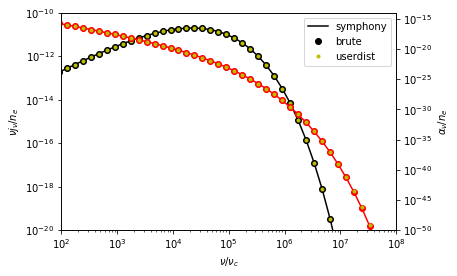

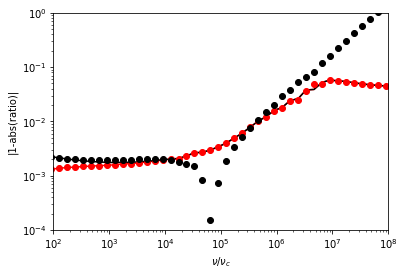

In [4]:
plt.figure(figsize=(6,4))

plt.loglog(nu/nu_c, j_nu_th_sym*nu, 'k-', label="symphony")
plt.loglog(nu/nu_c, j_nu_th_br*nu, 'ko', label="brute")
plt.loglog(nu/nu_c, j_nu_th_usr*nu, 'y.', label="userdist")

plt.ylim([1e-20, 1e-10])
plt.ylabel(r"$\nu j_{\nu}/n_e$")
plt.xlabel(r"$\nu/\nu_c$")
plt.legend()

plt.gca().twinx()
plt.loglog(nu/nu_c, a_nu_th_sym, 'r-')
plt.loglog(nu/nu_c, a_nu_th_br, 'ro')
plt.loglog(nu/nu_c, a_nu_th_usr, 'y.')

plt.ylim([1e-50, 1e-14])
plt.xlim([1e2, 1e8])
plt.ylabel(r"$\alpha_{\nu}/n_e$")

if SAVE_PLOT: plt.savefig("CompThermal.eps", bbox_inches="tight", dpi=300);

plt.figure(figsize=(6,4))

plt.loglog(nu/nu_c, np.abs(1-j_nu_th_br/j_nu_th_sym), 'r-')
plt.loglog(nu/nu_c, np.abs(1-a_nu_th_br/a_nu_th_sym), 'k-')
plt.loglog(nu/nu_c, np.abs(1-j_nu_th_usr/j_nu_th_sym), 'ro')
plt.loglog(nu/nu_c, np.abs(1-a_nu_th_usr/a_nu_th_sym), 'ko')
plt.ylabel("|1-abs(ratio)|")
plt.xlabel(r"$\nu/\nu_c$")
plt.xlim([1e2, 1e8])
plt.ylim([1e-4, 1])

## Powerlaw Distribution

In [5]:
gamma = np.logspace(np.log10(g_min_br), np.log10(g_max_br), 350)
ne_fun = lambda gamma : fm.eDist(gamma, ne, [p, gamma_min, gamma_max], "powerlawexpcutoff")

j_nu_pl_sym = j_nu_sym(nu, ne, B, [p, gamma_min, gamma_max], "powerlaw", p_angle)
a_nu_pl_sym = a_nu_sym(nu, ne, B, [p, gamma_min, gamma_max], "powerlaw", p_angle)

j_nu_pl_br = fm.j_nu_brute(nu, ne, B, [p, gamma_min, gamma_max], "powerlawexpcutoff", incang=p_angle, steps=steps)
j_nu_pl_usr = fm.j_nu_userdist(nu, B, gamma, ne_fun(gamma), incang=p_angle)
a_nu_pl_br = fm.a_nu_brute(nu, ne, B, [p, gamma_min, gamma_max], "powerlawexpcutoff", incang=p_angle, steps=steps)
a_nu_pl_usr = fm.a_nu_userdist(nu, B, gamma, ne_fun(gamma), incang=p_angle)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(0.0001, 1)

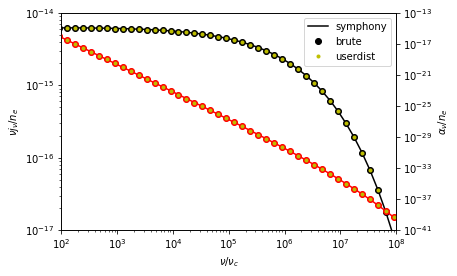

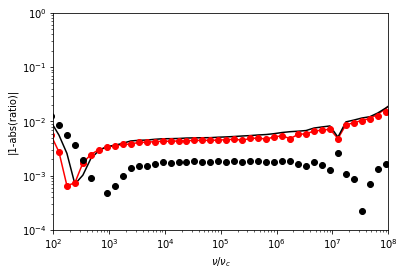

In [6]:
plt.figure(figsize=(6,4))

plt.loglog(nu/nu_c, j_nu_pl_sym*nu, 'k-', label="symphony")
plt.loglog(nu/nu_c, j_nu_pl_br*nu, 'ko', label="brute")
plt.loglog(nu/nu_c, j_nu_pl_usr*nu, 'y.', label="userdist")

plt.ylim([1e-17, 1e-14])

plt.ylabel(r"$\nu j_{\nu}/n_e$")
plt.xlabel(r"$\nu/\nu_c$")
plt.legend()

plt.gca().twinx()
plt.loglog(nu/nu_c, a_nu_pl_sym, 'r-')
plt.loglog(nu/nu_c, a_nu_pl_br, 'ro')
plt.loglog(nu/nu_c, a_nu_pl_usr, 'y.')

plt.ylim([1e-41, 1e-13])
plt.xlim([1e2, 1e8])
plt.ylabel(r"$\alpha_{\nu}/n_e$")

if SAVE_PLOT: plt.savefig("CompPl.eps", bbox_inches="tight", dpi=300);
    
plt.figure(figsize=(6, 4))

plt.loglog(nu/nu_c, np.abs(1-j_nu_pl_br/j_nu_pl_sym), 'r-')
plt.loglog(nu/nu_c, np.abs(1-a_nu_pl_br/a_nu_pl_sym), 'k-')
plt.loglog(nu/nu_c, np.abs(1-j_nu_pl_usr/j_nu_pl_sym), 'ro')
plt.loglog(nu/nu_c, np.abs(1-a_nu_pl_usr/a_nu_pl_sym), 'ko')
plt.ylabel("|1-abs(ratio)|")
plt.xlabel(r"$\nu/\nu_c$")
plt.xlim([1e2, 1e8])
plt.ylim([1e-4, 1])

In [7]:
gamma = np.logspace(np.log10(g_min_br), np.log10(g_max_br), 350)
ne_fun = lambda gamma : fm.eDist(gamma, ne, [kappa, kappa_w], "kappa")

j_nu_kp_sym = j_nu_sym(nu, ne, B, [kappa, kappa_w], "kappa", p_angle)
a_nu_kp_sym = a_nu_sym(nu, ne, B, [kappa, kappa_w], "kappa", p_angle)

j_nu_kp_br = fm.j_nu_brute(nu, ne, B, [kappa, kappa_w], "kappa", incang=p_angle, \
                           steps=steps, gamma_min=g_min_br, gamma_max=g_max_br)
j_nu_kp_usr = fm.j_nu_userdist(nu, B, gamma, ne_fun(gamma), incang=p_angle)
a_nu_kp_br = fm.a_nu_brute(nu, ne, B, [kappa, kappa_w], "kappa", incang=p_angle, \
                           steps=steps, gamma_min=g_min_br, gamma_max=g_max_br)
a_nu_kp_usr = fm.a_nu_userdist(nu, B, gamma, ne_fun(gamma), incang=p_angle)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(0.0001, 1)

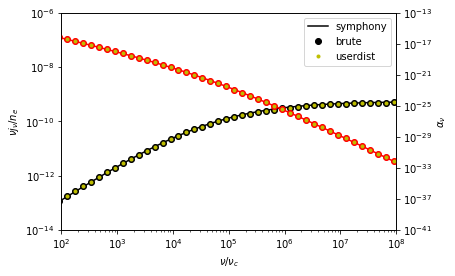

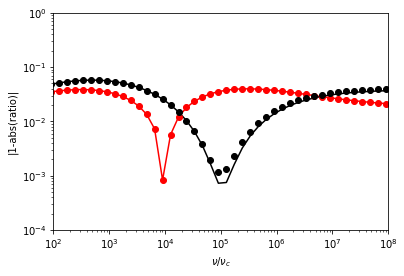

In [8]:
plt.figure(figsize=(6,4))

plt.loglog(nu/nu_c, j_nu_kp_sym*nu, 'k-', label="symphony")
plt.loglog(nu/nu_c, j_nu_kp_br*nu, 'ko', label="brute")
plt.loglog(nu/nu_c, j_nu_kp_usr*nu, 'y.', label="userdist")

plt.ylim([1e-14, 1e-6])
plt.ylabel(r"$\nu j_{\nu}/n_e$")
plt.xlabel(r"$\nu/\nu_c$")
plt.legend()

plt.gca().twinx()
plt.loglog(nu/nu_c, a_nu_kp_sym, 'r-')
plt.loglog(nu/nu_c, a_nu_kp_br, 'ro')
plt.loglog(nu/nu_c, a_nu_kp_usr, 'y.')

plt.ylim([1e-41, 1e-13])
plt.xlim([1e2, 1e8])
plt.ylabel(r"$\alpha_{\nu}$")

if SAVE_PLOT: plt.savefig("CompKappa.eps", bbox_inches="tight", dpi=300);

plt.figure(figsize=(6,4))

plt.loglog(nu/nu_c, np.abs(1-j_nu_kp_br/j_nu_kp_sym), 'r-')
plt.loglog(nu/nu_c, np.abs(1-a_nu_kp_br/a_nu_kp_sym), 'k-')
plt.loglog(nu/nu_c, np.abs(1-j_nu_kp_usr/j_nu_kp_sym), 'ro')
plt.loglog(nu/nu_c, np.abs(1-a_nu_kp_usr/a_nu_kp_sym), 'ko')
plt.ylabel("|1-abs(ratio)|")
plt.xlabel(r"$\nu/\nu_c$")
plt.xlim([1e2, 1e8])
plt.ylim([1e-4, 1])